## Train Network to Drive Car in Simulation

## Solution design approach

In order to derive a good mode, I decided to start by collecting two big sets of data of driving forward 1 lap and driving in the opposite directions for 1 lap. Then I collect some data that guide the model to make the correct turn near the left edge and right edge of the road. 

Then I come up with some certain model and train it with the data I have. The, I spend time to test out the model and adding more data at specific location where the car behaves inconsistently or keeps getting stuck. 

In [1]:
import cv2
import keras
import tensorflow as tf
import csv
import numpy as np
import os 

Using TensorFlow backend.


In [2]:
import os
######
CENTER_IDX = 0
LEFT_IDX = 1
RIGHT_IDX = 2
STEERING_ANGLE_IDX = 3


#### READ INPUT DATA

In [3]:


def extract_file_name(file):
    """
    Assume last backslash
    """
    assert(file is not None)
    name_start = file.rfind("/")
    return file[name_start+1:]


def read_input_dir(folder_name, raw_inputs):
    # OPEN data folder to read data
    # load csv file
    if not os.path.exists(folder_name):
        raise Exception('folder %s does not exist' % folder_name)
    with open(folder_name + "/driving_log.csv") as f:
        reader = csv.reader(f)
        for data in reader:
            # extract name 
            center_img = os.path.join(folder_name+"/IMG", extract_file_name(data[CENTER_IDX]))
            # append data 
            raw_inputs.append((center_img, float(data[STEERING_ANGLE_IDX])))
            

        
        

        

### STRATEGY FOR COLLECTING DATA 

My goal is to train a model be able to drive both easy and difficult routes. Therefore, I have been spending quite some amount of time to collect data especially for the difficult route. 

There are many spots on the difficult drive that the model does not behave so well that I had to collect much more data.

In general, I also keep observing the model during the run to pickout the spot where it does not behave so well leading to the car get stuck and manually adding data for those specific location. 

I also spend time to collect a lot of data from each side fof the road in order to train the model to always steer toward the middle of the road as much as it can. 


In [4]:
raw_inputs = []
# read each data folder
folder_list = [
    "../collect_data/drive_forward_data",
    "../collect_data/drive_reverse_data",
    "../collect_data/drive_left_data",
    "../collect_data/drive_right_data",
    "../collect_data2/side_drive_data_1",
    "../collect_data2/side_drive_data2",
    "../collect_data3/bridge_data",
    "data/improve_easy_drive",
    "../collect_data4",
    "../collect_data5",
    "../diff_data/diff_data1",
    "../diff_data/diff_data2",
    "../diff_data/diff_data3",
    "../diff_data/diff_data4",
    "../diff_data/diff_data5",
    "../diff_data/diff_data6",
    "../diff_data2/diff_data7",
    "../new_data/diff_data",
    "../new_data/diff_data2",
    "../new_data/diff_data3",
    "../new_data/diff_dat4",
    "../new_data/diff_data4",
    "../new_data/diff_data5",
    "../new_data/diff_data6",
    "../new_data/diff_data7",
    "../new_data/diff_data8",
    "../new_data/diff_data9",
    "../new_data/diff_data10",
    "../new_data/diff_data11",
    "../new_data/diff_data12",
    "../new_data/diff_data13"
]

# Read all data 
for each_folder in folder_list:
    read_input_dir(each_folder, raw_inputs)
    print (len(raw_inputs))


2797
5893
6867
8360
9330
10560
11652
12444
14530
15882
18088
20240
20932
21305
21569
23991
24671
25518
26775
27171
28602
29754
30659
31768
32829
34622
35056
35318
35632
37017
37960


### Characteristic of the dataset 

In order to improve the performance of the models to meet the safety requirements of the project, I have to collect specifically collect data to teach the model to steer away from dangerous area or undrivable surfaces. 

Specifically, I manually place the car in the direction toward the edges of the road and recording the moment I tried to steer the car toward the center of the road to enhance the habit of the model to always steer toward the center whenever you are too close to the edges.

Below are some of the images that illustrate the process:

In [11]:
import glob
import matplotlib.pyplot as plt
%matplotlib inline
drive_images = glob.glob("data/improve_easy_drive/*/center*.jpg")

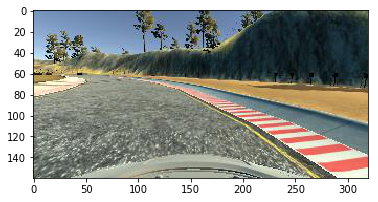

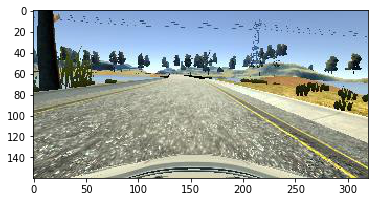

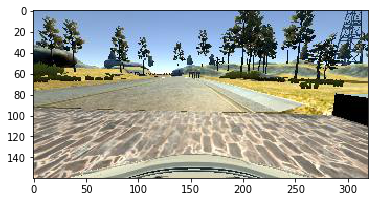

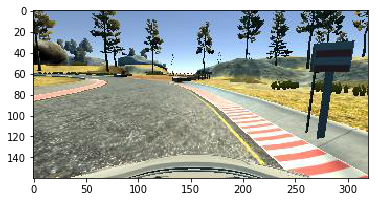

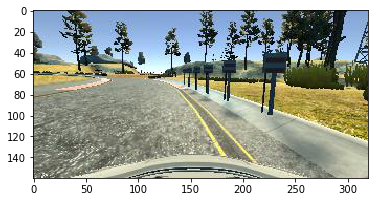

In [21]:
plt.figure()
plt.imshow(plt.imread(drive_images[80]))
plt.figure()
plt.imshow(plt.imread(drive_images[20]))
plt.figure()
plt.imshow(plt.imread(drive_images[0]))
plt.figure()
plt.imshow(plt.imread(drive_images[100]))
plt.figure()
plt.imshow(plt.imread(drive_images[150]))

### Create training and test dataset

I use sklearn **train_test_split** to split the dataset into 80% training and 20% test with shuffle as default option.

In [5]:
# convert to numpy array
from sklearn.model_selection import train_test_split
raw_inputs = np.array(raw_inputs)
train_raw_inputs, validation_raw_inputs = train_test_split(raw_inputs, test_size=0.1)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

### GENERATOR FOR CREATE BATCH DATA

In [7]:
from sklearn.utils import shuffle
# CENTEER
def data_generator(raw_inputs, batch_size=32):
    total_samples = len(raw_inputs)
    print(raw_inputs.shape)
    while 1:
        for offset in range(0, total_samples, batch_size):
            samples = raw_inputs[offset:offset+batch_size]
            inputs = []
            labels = []
            for sample in samples:
                if (not os.path.exists(sample[0])):
                    print("Failed %s " % sample[0])
                inputs.append(cv2.cvtColor(cv2.imread(sample[0]), cv2.COLOR_BGR2RGB))
                labels.append(sample[1])
            X_train = np.array(inputs)
            Y_train = np.array(labels)
            yield shuffle(X_train, Y_train)

### SPLIT DATA AND CREATE GENERATOR

Here I passed the training data set above to the **data_generator** function so we can use python generator feature to optimize memory usage better

In [8]:
train_generator = data_generator(train_raw_inputs)
validation_generator = data_generator(validation_raw_inputs)

## NETWORK ARCHITECTURE AND TRAINING

In order to come up with the final network archiecture, I have gone through an empirical process by first starting with a simple architecture and then gradually adding more layers as more data added to help the model be able to learn more features and not overfitting.

The final model architecture include:
- A lambda layers to normalize input data as neural network works better with small values between 0 to 1.
- A cropping layer in order to extract only interested area of the image that related to making steering decision.
- A convolution layer with 24 kernels of size 5x5 
- A convolution layer with 36 kernels of size 5x5 
- A convolution layer with 48 kernels of size 5x5
- A convolution layer with 64 kernels of size 3x3
- A convolution layer with 64 kernels of size 3x3
- A linear dense layer of size 100
- A linear dense layer of size 50
- A linear dense layer of size 1 (final output values)


In order to avoid overfitting, I have applied some well-known techniques:
- For the first 3 convolution layers, I added the maxpool layer with kernel of size 2x2 to reduce complicated details and help the network train faster.
- Each network layer outputs (except the last one) are activated with non-linear relu function.
- Adding dropout layer between each network layers to help the network generalize better as well as train faster.
- Using BatchNormalization layer also helps to reduce the affects of previous layer ouputs to the current layer inputs so the network can be trained faster.

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dropout, MaxPooling2D, Dense, Lambda, Cropping2D, BatchNormalization
from keras.callbacks import ModelCheckpoint

In [10]:
def create_model():
    model = Sequential()
    # normalize input 
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((70,25),(0,0)))) 
    model.add(Conv2D(24, 5, 5,activation='relu', subsample=(2,2))) # input: 65x320x3, 31x158x3x16
    model.add(BatchNormalization())
    model.add(Dropout(p=0.2))
    model.add(Conv2D(36, 5, 5,activation='relu',subsample=(2,2))) # input: 31x158x3x32, 13x76x3x32
    model.add(BatchNormalization())
    model.add(Dropout(p=0.2))
    model.add(Conv2D(48, 5, 5,activation='relu',subsample=(2,2))) # input: 31x158x3x32, 13x76x3x32 
    model.add(BatchNormalization())
    model.add(Dropout(p=0.2))
    model.add(Conv2D(64, 3, 3,activation='relu')) # input: 31x158x3x32, 13x76x3x32 
    model.add(BatchNormalization())
    model.add(Dropout(p=0.2))
    model.add(Conv2D(64, 3, 3,activation='relu')) # input: 31x158x3x32, 13x76x3x32 
    model.add(Dropout(p=0.2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(p=0.4))
    model.add(Dense(50, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(p=0.4))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    return model

### TRAINING PROCESS

I set the number of epochs to be 100. In order to avoid overfit and saving time during training, I allow the model to be saved during the training  if there is improvement on validation loss. After about every 10 epochs, I take the best model and try it on the simulation and pick the model that is able to drive the whole lap without getting stuck.

Then I test the model on the easy route to make sure that it also learnt to drive well with the easy one.


In [11]:
filepath="full_model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callback_list = [checkpoint]

In [12]:
my_model = create_model()

In [13]:
my_model.fit_generator(train_generator, samples_per_epoch=len(train_raw_inputs), callbacks=callback_list,nb_epoch=100, 
               validation_data=validation_generator, nb_val_samples=len(validation_raw_inputs))

(34164, 2)
Epoch 1/100
34144/34164 [============================>.] - ETA: 0s - loss: 0.6489 - acc: 0.3324(3796, 2)
Epoch 00000: val_loss improved from inf to 0.16764, saving model to full_model.hdf5
34164/34164 [==============================] - 67s - loss: 0.6486 - acc: 0.3323 - val_loss: 0.1676 - val_acc: 0.4394
Epoch 2/100
34164/34164 [==============================] - 56s - loss: 0.1875 - acc: 0.4245 - val_loss: 0.1640 - val_acc: 0.4589
Epoch 3/100
34164/34164 [==============================] - 56s - loss: 0.1729 - acc: 0.4395 - val_loss: 0.1472 - val_acc: 0.4789
Epoch 4/100
34164/34164 [==============================] - 56s - loss: 0.1655 - acc: 0.4501 - val_loss: 0.1437 - val_acc: 0.4779
Epoch 5/100
34164/34164 [==============================] - 56s - loss: 0.1609 - acc: 0.4538 - val_loss: 0.1403 - val_acc: 0.4839
Epoch 6/100
34164/34164 [==============================] - 56s - loss: 0.1569 - acc: 0.4583 - val_loss: 0.1363 - val_acc: 0.4879
Epoch 7/100
34164/34164 [=============

KeyboardInterrupt: 

In [76]:
my_model.save('my_model.h5')

## FINAL RESULTS

The best model is renamed in the root folder **best_model.hdf5**

Due to the large size of the video files, I uploaded them to my google drive. You can download them by click on the link below:
https://drive.google.com/drive/folders/1QQkLCBV3z32qcBOmm3jzJsHnZ8O8799F?usp=sharing

My model is able to complete the drive of the easy route with max speed at 20. 

However, it is only able to complete the difficult drive with the max speed of 12. Due to the sharp turns that the model is not able to deal with at such high speed. 



